In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import keras
import keras.backend as K
from keras.layers import Conv1D, MaxPool1D, Dropout, UpSampling1D, Input, Flatten, Dense, LeakyReLU
from keras.models import *
from keras import optimizers
from keras.layers.merge import concatenate
from keras.callbacks import *

from construct_models import *

Using TensorFlow backend.
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/buikhoi/.local/lib/python3.6/site-packages/tensorflow/py

In [2]:
def prepare_old_model(input_shape = (223, 1)):
    model = Sequential()

    model.add(Conv1D(16, 5, activation = 'relu', input_shape = input_shape))
    model.add(MaxPool1D(2, 2))
    model.add(Conv1D(32, 5, activation = 'relu'))
    model.add(MaxPool1D(2, 2))
    model.add(Conv1D(64, 5, activation = 'relu'))
    model.add(MaxPool1D(2, 2))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.3))
    model.add(Dense(9, activation='softmax'))
    return model

In [9]:
def prepare_nir_resnet_model(input_shape = (230, 3)):
    inpt = Input(input_shape)
    
    conv1 = Conv1D(16, 3, padding='same')(inpt)
    conv1 = LeakyReLU()(conv1)
    conv1 = concatenate([inpt, conv1], 2)
    conv1 = Conv1D(32, 3, padding='same')(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPool1D(2, 2)(conv1)
    
    conv2 = Conv1D(32, 3, padding='same')(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = concatenate([pool1, conv2], 2)
    conv2 = Conv1D(64, 3, padding='same')(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPool1D(2, 2)(conv2)
    
#     conv3 = Conv1D(16, 3, padding='same')(pool2)
#     conv3 = LeakyReLU()(conv3)
#     conv3 = concatenate([pool2, conv3], 2)
#     conv3 = Conv1D(32, 3, padding='same')(conv3)
#     conv3 = LeakyReLU()(conv3)
#     pool3 = MaxPool1D(2, 2)(conv3)
    
#     conv4 = Conv1D(32, 3, padding='same')(pool3)
#     conv4 = LeakyReLU()(conv4)
#     conv4 = concatenate([pool3, conv4], 2)
#     conv4 = Conv1D(64, 3, padding='same')(conv4)
#     conv4 = LeakyReLU()(conv4)
#     pool4 = MaxPool1D(2, 2)(conv4)
    
    flatt = Flatten()(pool2)
    dens0 = Dense(128)(flatt)
    dens0 = LeakyReLU()(dens0)
    drop0 = Dropout(0.5)(dens0)
    
    dens1 = Dense(256)(drop0)
    dens1 = LeakyReLU()(dens1)
    drop1 = Dropout(0.5)(dens1)
    outpt = Dense(9, activation='softmax')(drop1)
    
    return Model(inpt, outpt)

In [10]:
model = prepare_nir_resnet_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 230, 3)       0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 230, 16)      160         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 230, 16)      0           conv1d_5[0][0]                   
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 230, 19)      0           input_2[0][0]                    
                                                                 leaky_re_lu_7[0][0]        

In [11]:
adam = optimizers.Adam(0.0001, 0.9, 0.99)
model.compile(adam, 'categorical_crossentropy', ['accuracy'])

In [12]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose = 1)
checkpoint = callbacks.ModelCheckpoint('./Checkpoints/Weight/fruit_classify_3l_resnet.h5', 'val_accuracy', 1, True)
early_stop = callbacks.EarlyStopping('val_loss', patience=200, verbose=1, restore_best_weights=True)

In [13]:
temp = np.load('./Data/Training data/training_3layers.npz')
X_data = temp['xdata']
y_true = temp['ytrue']
y_hot = np.zeros((len(y_true), 9))
y_hot[np.arange(len(y_true)), y_true] = 1
X_train, X_test, y_train, y_test = train_test_split(X_data, y_hot)

In [14]:
history = model.fit(X_train, y_train, 128, 3000, 1, [checkpoint], validation_data=(X_test, y_test))

Train on 822 samples, validate on 275 samples
Epoch 1/3000
822/822 [==============================] - 1s 1ms/step - loss: 2.0747 - accuracy: 0.1886 - val_loss: 1.8244 - val_accuracy: 0.1782

Epoch 00001: val_accuracy improved from -inf to 0.17818, saving model to ./Checkpoints/Weight/fruit_classify_3l_resnet.h5
Epoch 2/3000
822/822 [==============================] - 0s 68us/step - loss: 1.8943 - accuracy: 0.2056 - val_loss: 1.7220 - val_accuracy: 0.1782

Epoch 00002: val_accuracy did not improve from 0.17818
Epoch 3/3000
822/822 [==============================] - 0s 63us/step - loss: 1.7977 - accuracy: 0.2348 - val_loss: 1.6716 - val_accuracy: 0.2582

Epoch 00003: val_accuracy improved from 0.17818 to 0.25818, saving model to ./Checkpoints/Weight/fruit_classify_3l_resnet.h5
Epoch 4/3000
822/822 [==============================] - 0s 66us/step - loss: 1.8041 - accuracy: 0.2007 - val_loss: 1.6535 - val_accuracy: 0.3055

Epoch 00004: val_accuracy improved from 0.25818 to 0.30545, saving mo

822/822 [==============================] - 0s 67us/step - loss: 1.0286 - accuracy: 0.6034 - val_loss: 0.9496 - val_accuracy: 0.6945

Epoch 00036: val_accuracy did not improve from 0.70545
Epoch 37/3000
822/822 [==============================] - 0s 63us/step - loss: 1.0143 - accuracy: 0.6302 - val_loss: 0.9402 - val_accuracy: 0.7164

Epoch 00037: val_accuracy improved from 0.70545 to 0.71636, saving model to ./Checkpoints/Weight/fruit_classify_3l_resnet.h5
Epoch 38/3000
822/822 [==============================] - 0s 73us/step - loss: 1.0336 - accuracy: 0.6144 - val_loss: 0.9320 - val_accuracy: 0.6691

Epoch 00038: val_accuracy did not improve from 0.71636
Epoch 39/3000
822/822 [==============================] - 0s 73us/step - loss: 0.9826 - accuracy: 0.6363 - val_loss: 0.9240 - val_accuracy: 0.6909

Epoch 00039: val_accuracy did not improve from 0.71636
Epoch 40/3000
822/822 [==============================] - 0s 72us/step - loss: 0.9801 - accuracy: 0.6363 - val_loss: 0.8987 - val_accurac

822/822 [==============================] - 0s 76us/step - loss: 0.5831 - accuracy: 0.8139 - val_loss: 0.6457 - val_accuracy: 0.8000

Epoch 00074: val_accuracy did not improve from 0.80000
Epoch 75/3000
822/822 [==============================] - 0s 67us/step - loss: 0.5477 - accuracy: 0.8406 - val_loss: 0.6272 - val_accuracy: 0.7927

Epoch 00075: val_accuracy did not improve from 0.80000
Epoch 76/3000
822/822 [==============================] - 0s 57us/step - loss: 0.5737 - accuracy: 0.8175 - val_loss: 0.6207 - val_accuracy: 0.7927

Epoch 00076: val_accuracy did not improve from 0.80000
Epoch 77/3000
822/822 [==============================] - 0s 79us/step - loss: 0.5395 - accuracy: 0.8297 - val_loss: 0.6095 - val_accuracy: 0.8000

Epoch 00077: val_accuracy did not improve from 0.80000
Epoch 78/3000
822/822 [==============================] - 0s 79us/step - loss: 0.5512 - accuracy: 0.8297 - val_loss: 0.6121 - val_accuracy: 0.7891

Epoch 00078: val_accuracy did not improve from 0.80000
Epoc

822/822 [==============================] - 0s 76us/step - loss: 0.3040 - accuracy: 0.9221 - val_loss: 0.5246 - val_accuracy: 0.8327

Epoch 00113: val_accuracy did not improve from 0.83273
Epoch 114/3000
822/822 [==============================] - 0s 66us/step - loss: 0.3075 - accuracy: 0.9100 - val_loss: 0.5314 - val_accuracy: 0.8109

Epoch 00114: val_accuracy did not improve from 0.83273
Epoch 115/3000
822/822 [==============================] - 0s 75us/step - loss: 0.2982 - accuracy: 0.9221 - val_loss: 0.5526 - val_accuracy: 0.8364

Epoch 00115: val_accuracy improved from 0.83273 to 0.83636, saving model to ./Checkpoints/Weight/fruit_classify_3l_resnet.h5
Epoch 116/3000
822/822 [==============================] - 0s 70us/step - loss: 0.3000 - accuracy: 0.9185 - val_loss: 0.5438 - val_accuracy: 0.8109

Epoch 00116: val_accuracy did not improve from 0.83636
Epoch 117/3000
822/822 [==============================] - 0s 66us/step - loss: 0.3143 - accuracy: 0.9075 - val_loss: 0.5352 - val_acc

822/822 [==============================] - 0s 85us/step - loss: 0.1545 - accuracy: 0.9550 - val_loss: 0.5310 - val_accuracy: 0.8255

Epoch 00153: val_accuracy did not improve from 0.83636
Epoch 154/3000
822/822 [==============================] - 0s 80us/step - loss: 0.1625 - accuracy: 0.9635 - val_loss: 0.4976 - val_accuracy: 0.8255

Epoch 00154: val_accuracy did not improve from 0.83636
Epoch 155/3000
822/822 [==============================] - 0s 66us/step - loss: 0.1374 - accuracy: 0.9647 - val_loss: 0.5094 - val_accuracy: 0.8255

Epoch 00155: val_accuracy did not improve from 0.83636
Epoch 156/3000
822/822 [==============================] - 0s 81us/step - loss: 0.1506 - accuracy: 0.9599 - val_loss: 0.5518 - val_accuracy: 0.8182

Epoch 00156: val_accuracy did not improve from 0.83636
Epoch 157/3000
822/822 [==============================] - 0s 61us/step - loss: 0.1587 - accuracy: 0.9538 - val_loss: 0.5039 - val_accuracy: 0.8291

Epoch 00157: val_accuracy did not improve from 0.83636


Epoch 193/3000
822/822 [==============================] - 0s 66us/step - loss: 0.0612 - accuracy: 0.9878 - val_loss: 0.5630 - val_accuracy: 0.8109

Epoch 00193: val_accuracy did not improve from 0.84000
Epoch 194/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0716 - accuracy: 0.9854 - val_loss: 0.5458 - val_accuracy: 0.8327

Epoch 00194: val_accuracy did not improve from 0.84000
Epoch 195/3000
822/822 [==============================] - 0s 70us/step - loss: 0.0672 - accuracy: 0.9878 - val_loss: 0.5729 - val_accuracy: 0.8182

Epoch 00195: val_accuracy did not improve from 0.84000
Epoch 196/3000
822/822 [==============================] - 0s 72us/step - loss: 0.0666 - accuracy: 0.9854 - val_loss: 0.5803 - val_accuracy: 0.8109

Epoch 00196: val_accuracy did not improve from 0.84000
Epoch 197/3000
822/822 [==============================] - 0s 69us/step - loss: 0.0641 - accuracy: 0.9854 - val_loss: 0.5940 - val_accuracy: 0.8255

Epoch 00197: val_accuracy did not improv

822/822 [==============================] - 0s 62us/step - loss: 0.0341 - accuracy: 0.9927 - val_loss: 0.6123 - val_accuracy: 0.8218

Epoch 00233: val_accuracy did not improve from 0.84727
Epoch 234/3000
822/822 [==============================] - 0s 65us/step - loss: 0.0274 - accuracy: 0.9927 - val_loss: 0.6560 - val_accuracy: 0.8255

Epoch 00234: val_accuracy did not improve from 0.84727
Epoch 235/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0285 - accuracy: 0.9951 - val_loss: 0.6394 - val_accuracy: 0.8364

Epoch 00235: val_accuracy did not improve from 0.84727
Epoch 236/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0313 - accuracy: 0.9915 - val_loss: 0.6525 - val_accuracy: 0.8145

Epoch 00236: val_accuracy did not improve from 0.84727
Epoch 237/3000
822/822 [==============================] - 0s 77us/step - loss: 0.0304 - accuracy: 0.9927 - val_loss: 0.6186 - val_accuracy: 0.8327

Epoch 00237: val_accuracy did not improve from 0.84727


822/822 [==============================] - 0s 67us/step - loss: 0.0305 - accuracy: 0.9891 - val_loss: 0.6945 - val_accuracy: 0.8364

Epoch 00273: val_accuracy did not improve from 0.84727
Epoch 274/3000
822/822 [==============================] - 0s 87us/step - loss: 0.0298 - accuracy: 0.9939 - val_loss: 0.7107 - val_accuracy: 0.8182

Epoch 00274: val_accuracy did not improve from 0.84727
Epoch 275/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0227 - accuracy: 0.9939 - val_loss: 0.7104 - val_accuracy: 0.8145

Epoch 00275: val_accuracy did not improve from 0.84727
Epoch 276/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0218 - accuracy: 0.9964 - val_loss: 0.7378 - val_accuracy: 0.8073

Epoch 00276: val_accuracy did not improve from 0.84727
Epoch 277/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0154 - accuracy: 0.9976 - val_loss: 0.7141 - val_accuracy: 0.8109

Epoch 00277: val_accuracy did not improve from 0.84727


822/822 [==============================] - 0s 64us/step - loss: 0.0127 - accuracy: 0.9988 - val_loss: 0.6778 - val_accuracy: 0.8327

Epoch 00313: val_accuracy did not improve from 0.85091
Epoch 314/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0176 - accuracy: 0.9939 - val_loss: 0.6908 - val_accuracy: 0.8364

Epoch 00314: val_accuracy did not improve from 0.85091
Epoch 315/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0216 - accuracy: 0.9951 - val_loss: 0.6757 - val_accuracy: 0.8364

Epoch 00315: val_accuracy did not improve from 0.85091
Epoch 316/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0293 - accuracy: 0.9903 - val_loss: 0.6932 - val_accuracy: 0.8291

Epoch 00316: val_accuracy did not improve from 0.85091
Epoch 317/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0213 - accuracy: 0.9927 - val_loss: 0.7463 - val_accuracy: 0.8218

Epoch 00317: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 63us/step - loss: 0.0231 - accuracy: 0.9927 - val_loss: 0.8383 - val_accuracy: 0.7927

Epoch 00353: val_accuracy did not improve from 0.85091
Epoch 354/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0186 - accuracy: 0.9964 - val_loss: 0.7296 - val_accuracy: 0.8291

Epoch 00354: val_accuracy did not improve from 0.85091
Epoch 355/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0232 - accuracy: 0.9927 - val_loss: 0.7847 - val_accuracy: 0.8073

Epoch 00355: val_accuracy did not improve from 0.85091
Epoch 356/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0158 - accuracy: 0.9964 - val_loss: 0.6862 - val_accuracy: 0.8255

Epoch 00356: val_accuracy did not improve from 0.85091
Epoch 357/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0096 - accuracy: 0.9988 - val_loss: 0.6815 - val_accuracy: 0.8400

Epoch 00357: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 61us/step - loss: 0.0094 - accuracy: 0.9988 - val_loss: 0.8439 - val_accuracy: 0.8109

Epoch 00393: val_accuracy did not improve from 0.85091
Epoch 394/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.8144 - val_accuracy: 0.8327

Epoch 00394: val_accuracy did not improve from 0.85091
Epoch 395/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.8055 - val_accuracy: 0.8182

Epoch 00395: val_accuracy did not improve from 0.85091
Epoch 396/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 0.8427 - val_accuracy: 0.8182

Epoch 00396: val_accuracy did not improve from 0.85091
Epoch 397/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0077 - accuracy: 0.9988 - val_loss: 0.8068 - val_accuracy: 0.8145

Epoch 00397: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 60us/step - loss: 0.0050 - accuracy: 0.9976 - val_loss: 0.8866 - val_accuracy: 0.8255

Epoch 00433: val_accuracy did not improve from 0.85091
Epoch 434/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.8756 - val_accuracy: 0.8364

Epoch 00434: val_accuracy did not improve from 0.85091
Epoch 435/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 0.9597 - val_accuracy: 0.8000

Epoch 00435: val_accuracy did not improve from 0.85091
Epoch 436/3000
822/822 [==============================] - 0s 65us/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.8330 - val_accuracy: 0.8364

Epoch 00436: val_accuracy did not improve from 0.85091
Epoch 437/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.8735 - val_accuracy: 0.8145

Epoch 00437: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 66us/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 1.0011 - val_accuracy: 0.8145

Epoch 00473: val_accuracy did not improve from 0.85091
Epoch 474/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 1.1243 - val_accuracy: 0.7818

Epoch 00474: val_accuracy did not improve from 0.85091
Epoch 475/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.0583 - val_accuracy: 0.8000

Epoch 00475: val_accuracy did not improve from 0.85091
Epoch 476/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0053 - accuracy: 0.9988 - val_loss: 1.0114 - val_accuracy: 0.8145

Epoch 00476: val_accuracy did not improve from 0.85091
Epoch 477/3000
822/822 [==============================] - 0s 96us/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.9617 - val_accuracy: 0.8182

Epoch 00477: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 63us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.8987 - val_accuracy: 0.8400

Epoch 00513: val_accuracy did not improve from 0.85091
Epoch 514/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 1.1464 - val_accuracy: 0.7709

Epoch 00514: val_accuracy did not improve from 0.85091
Epoch 515/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.9814 - val_accuracy: 0.8218

Epoch 00515: val_accuracy did not improve from 0.85091
Epoch 516/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 0.9679 - val_accuracy: 0.8255

Epoch 00516: val_accuracy did not improve from 0.85091
Epoch 517/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.9501 - val_accuracy: 0.8255

Epoch 00517: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 63us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.9549 - val_accuracy: 0.8400

Epoch 00553: val_accuracy did not improve from 0.85091
Epoch 554/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.9743 - val_accuracy: 0.8291

Epoch 00554: val_accuracy did not improve from 0.85091
Epoch 555/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.9752 - val_accuracy: 0.8291

Epoch 00555: val_accuracy did not improve from 0.85091
Epoch 556/3000
822/822 [==============================] - 0s 66us/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 1.0219 - val_accuracy: 0.8145

Epoch 00556: val_accuracy did not improve from 0.85091
Epoch 557/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.9973 - val_accuracy: 0.8291

Epoch 00557: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 64us/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.9417 - val_accuracy: 0.8145

Epoch 00593: val_accuracy did not improve from 0.85091
Epoch 594/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.9644 - val_accuracy: 0.8109

Epoch 00594: val_accuracy did not improve from 0.85091
Epoch 595/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.9517 - val_accuracy: 0.8218

Epoch 00595: val_accuracy did not improve from 0.85091
Epoch 596/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9884 - val_accuracy: 0.8291

Epoch 00596: val_accuracy did not improve from 0.85091
Epoch 597/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9840 - val_accuracy: 0.8291

Epoch 00597: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 81us/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.9717 - val_accuracy: 0.8182

Epoch 00633: val_accuracy did not improve from 0.85091
Epoch 634/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.9782 - val_accuracy: 0.8327

Epoch 00634: val_accuracy did not improve from 0.85091
Epoch 635/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0450 - val_accuracy: 0.8218

Epoch 00635: val_accuracy did not improve from 0.85091
Epoch 636/3000
822/822 [==============================] - 0s 58us/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 1.0247 - val_accuracy: 0.8145

Epoch 00636: val_accuracy did not improve from 0.85091
Epoch 637/3000
822/822 [==============================] - 0s 57us/step - loss: 0.0038 - accuracy: 0.9976 - val_loss: 1.0082 - val_accuracy: 0.8218

Epoch 00637: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 61us/step - loss: 3.8627e-04 - accuracy: 1.0000 - val_loss: 1.0216 - val_accuracy: 0.8255

Epoch 00673: val_accuracy did not improve from 0.85091
Epoch 674/3000
822/822 [==============================] - 0s 63us/step - loss: 3.6112e-04 - accuracy: 1.0000 - val_loss: 1.0324 - val_accuracy: 0.8218

Epoch 00674: val_accuracy did not improve from 0.85091
Epoch 675/3000
822/822 [==============================] - 0s 65us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.0253 - val_accuracy: 0.8327

Epoch 00675: val_accuracy did not improve from 0.85091
Epoch 676/3000
822/822 [==============================] - 0s 64us/step - loss: 4.5559e-04 - accuracy: 1.0000 - val_loss: 1.0989 - val_accuracy: 0.8218

Epoch 00676: val_accuracy did not improve from 0.85091
Epoch 677/3000
822/822 [==============================] - 0s 63us/step - loss: 8.2059e-04 - accuracy: 1.0000 - val_loss: 1.0683 - val_accuracy: 0.8218

Epoch 00677: val_accuracy did not impro

822/822 [==============================] - 0s 64us/step - loss: 9.8893e-04 - accuracy: 1.0000 - val_loss: 1.0774 - val_accuracy: 0.8182

Epoch 00713: val_accuracy did not improve from 0.85091
Epoch 714/3000
822/822 [==============================] - 0s 64us/step - loss: 4.8097e-04 - accuracy: 1.0000 - val_loss: 1.0554 - val_accuracy: 0.8218

Epoch 00714: val_accuracy did not improve from 0.85091
Epoch 715/3000
822/822 [==============================] - 0s 58us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.0481 - val_accuracy: 0.8145

Epoch 00715: val_accuracy did not improve from 0.85091
Epoch 716/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.0910 - val_accuracy: 0.8000

Epoch 00716: val_accuracy did not improve from 0.85091
Epoch 717/3000
822/822 [==============================] - 0s 63us/step - loss: 6.7442e-04 - accuracy: 1.0000 - val_loss: 1.1143 - val_accuracy: 0.8000

Epoch 00717: val_accuracy did not improve f

822/822 [==============================] - 0s 66us/step - loss: 0.0288 - accuracy: 0.9878 - val_loss: 1.0945 - val_accuracy: 0.8182

Epoch 00753: val_accuracy did not improve from 0.85091
Epoch 754/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0081 - accuracy: 0.9951 - val_loss: 1.2109 - val_accuracy: 0.7927

Epoch 00754: val_accuracy did not improve from 0.85091
Epoch 755/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0127 - accuracy: 0.9951 - val_loss: 1.1960 - val_accuracy: 0.8000

Epoch 00755: val_accuracy did not improve from 0.85091
Epoch 756/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 1.1325 - val_accuracy: 0.7927

Epoch 00756: val_accuracy did not improve from 0.85091
Epoch 757/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 1.1967 - val_accuracy: 0.7782

Epoch 00757: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 62us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.1508 - val_accuracy: 0.8036

Epoch 00793: val_accuracy did not improve from 0.85091
Epoch 794/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 1.1108 - val_accuracy: 0.8182

Epoch 00794: val_accuracy did not improve from 0.85091
Epoch 795/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0093 - accuracy: 0.9988 - val_loss: 1.2506 - val_accuracy: 0.7855

Epoch 00795: val_accuracy did not improve from 0.85091
Epoch 796/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.1420 - val_accuracy: 0.8182

Epoch 00796: val_accuracy did not improve from 0.85091
Epoch 797/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0060 - accuracy: 0.9976 - val_loss: 1.1478 - val_accuracy: 0.8073

Epoch 00797: val_accuracy did not improve from 0.85091


822/822 [==============================] - 0s 64us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.2790 - val_accuracy: 0.8073

Epoch 00833: val_accuracy did not improve from 0.85091
Epoch 834/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 1.4153 - val_accuracy: 0.8182

Epoch 00834: val_accuracy did not improve from 0.85091
Epoch 835/3000
822/822 [==============================] - 0s 60us/step - loss: 0.0011 - accuracy: 0.9988 - val_loss: 1.2576 - val_accuracy: 0.8109

Epoch 00835: val_accuracy did not improve from 0.85091
Epoch 836/3000
822/822 [==============================] - 0s 62us/step - loss: 7.3449e-04 - accuracy: 1.0000 - val_loss: 1.2264 - val_accuracy: 0.8145

Epoch 00836: val_accuracy did not improve from 0.85091
Epoch 837/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.3058 - val_accuracy: 0.8000

Epoch 00837: val_accuracy did not improve from 0.85

822/822 [==============================] - 0s 62us/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 1.1328 - val_accuracy: 0.8182

Epoch 00873: val_accuracy did not improve from 0.85091
Epoch 874/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0051 - accuracy: 0.9976 - val_loss: 1.1751 - val_accuracy: 0.8073

Epoch 00874: val_accuracy did not improve from 0.85091
Epoch 875/3000
822/822 [==============================] - 0s 66us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.2121 - val_accuracy: 0.8073

Epoch 00875: val_accuracy did not improve from 0.85091
Epoch 876/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.1321 - val_accuracy: 0.8145

Epoch 00876: val_accuracy did not improve from 0.85091
Epoch 877/3000
822/822 [==============================] - 0s 59us/step - loss: 8.8104e-04 - accuracy: 1.0000 - val_loss: 1.1301 - val_accuracy: 0.8182

Epoch 00877: val_accuracy did not improve from 0.85

822/822 [==============================] - 0s 62us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.0797 - val_accuracy: 0.8145

Epoch 00913: val_accuracy did not improve from 0.85091
Epoch 914/3000
822/822 [==============================] - 0s 61us/step - loss: 5.6899e-04 - accuracy: 1.0000 - val_loss: 1.1044 - val_accuracy: 0.8255

Epoch 00914: val_accuracy did not improve from 0.85091
Epoch 915/3000
822/822 [==============================] - 0s 64us/step - loss: 5.6413e-04 - accuracy: 1.0000 - val_loss: 1.1174 - val_accuracy: 0.8218

Epoch 00915: val_accuracy did not improve from 0.85091
Epoch 916/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.0947 - val_accuracy: 0.8218

Epoch 00916: val_accuracy did not improve from 0.85091
Epoch 917/3000
822/822 [==============================] - 0s 60us/step - loss: 9.3141e-04 - accuracy: 1.0000 - val_loss: 1.1292 - val_accuracy: 0.8218

Epoch 00917: val_accuracy did not improve f

822/822 [==============================] - 0s 64us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.2435 - val_accuracy: 0.8073

Epoch 00953: val_accuracy did not improve from 0.85091
Epoch 954/3000
822/822 [==============================] - 0s 59us/step - loss: 4.8266e-04 - accuracy: 1.0000 - val_loss: 1.2292 - val_accuracy: 0.8145

Epoch 00954: val_accuracy did not improve from 0.85091
Epoch 955/3000
822/822 [==============================] - 0s 61us/step - loss: 2.7694e-04 - accuracy: 1.0000 - val_loss: 1.2068 - val_accuracy: 0.7927

Epoch 00955: val_accuracy did not improve from 0.85091
Epoch 956/3000
822/822 [==============================] - 0s 62us/step - loss: 2.1055e-04 - accuracy: 1.0000 - val_loss: 1.2010 - val_accuracy: 0.8073

Epoch 00956: val_accuracy did not improve from 0.85091
Epoch 957/3000
822/822 [==============================] - 0s 57us/step - loss: 3.2451e-04 - accuracy: 1.0000 - val_loss: 1.2045 - val_accuracy: 0.8036

Epoch 00957: val_accuracy did not impro

822/822 [==============================] - 0s 66us/step - loss: 6.1922e-04 - accuracy: 1.0000 - val_loss: 1.3326 - val_accuracy: 0.8109

Epoch 00993: val_accuracy did not improve from 0.85091
Epoch 994/3000
822/822 [==============================] - 0s 62us/step - loss: 6.3974e-04 - accuracy: 1.0000 - val_loss: 1.3614 - val_accuracy: 0.8109

Epoch 00994: val_accuracy did not improve from 0.85091
Epoch 995/3000
822/822 [==============================] - 0s 58us/step - loss: 3.0967e-04 - accuracy: 1.0000 - val_loss: 1.3838 - val_accuracy: 0.8182

Epoch 00995: val_accuracy did not improve from 0.85091
Epoch 996/3000
822/822 [==============================] - 0s 60us/step - loss: 2.7039e-04 - accuracy: 1.0000 - val_loss: 1.3697 - val_accuracy: 0.8182

Epoch 00996: val_accuracy did not improve from 0.85091
Epoch 997/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0026 - accuracy: 0.9988 - val_loss: 1.3916 - val_accuracy: 0.7782

Epoch 00997: val_accuracy did not impro


Epoch 01032: val_accuracy did not improve from 0.85091
Epoch 1033/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0143 - accuracy: 0.9927 - val_loss: 1.6118 - val_accuracy: 0.7964

Epoch 01033: val_accuracy did not improve from 0.85091
Epoch 1034/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.5005 - val_accuracy: 0.7782

Epoch 01034: val_accuracy did not improve from 0.85091
Epoch 1035/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0034 - accuracy: 0.9988 - val_loss: 1.3016 - val_accuracy: 0.8073

Epoch 01035: val_accuracy did not improve from 0.85091
Epoch 1036/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0058 - accuracy: 0.9976 - val_loss: 1.4352 - val_accuracy: 0.8000

Epoch 01036: val_accuracy did not improve from 0.85091
Epoch 1037/3000
822/822 [==============================] - 0s 60us/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 1.4148 - v


Epoch 01072: val_accuracy did not improve from 0.85091
Epoch 1073/3000
822/822 [==============================] - 0s 59us/step - loss: 9.6070e-04 - accuracy: 1.0000 - val_loss: 1.4312 - val_accuracy: 0.8036

Epoch 01073: val_accuracy did not improve from 0.85091
Epoch 1074/3000
822/822 [==============================] - 0s 63us/step - loss: 3.1307e-04 - accuracy: 1.0000 - val_loss: 1.5083 - val_accuracy: 0.8036

Epoch 01074: val_accuracy did not improve from 0.85091
Epoch 1075/3000
822/822 [==============================] - 0s 62us/step - loss: 8.4821e-04 - accuracy: 1.0000 - val_loss: 1.3989 - val_accuracy: 0.7891

Epoch 01075: val_accuracy did not improve from 0.85091
Epoch 1076/3000
822/822 [==============================] - 0s 58us/step - loss: 1.3396e-04 - accuracy: 1.0000 - val_loss: 1.4555 - val_accuracy: 0.7818

Epoch 01076: val_accuracy did not improve from 0.85091
Epoch 1077/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0066 - accuracy: 0.9988 - val_

822/822 [==============================] - 0s 61us/step - loss: 1.9989e-04 - accuracy: 1.0000 - val_loss: 1.5230 - val_accuracy: 0.8000

Epoch 01112: val_accuracy did not improve from 0.85091
Epoch 1113/3000
822/822 [==============================] - 0s 65us/step - loss: 1.6526e-04 - accuracy: 1.0000 - val_loss: 1.5621 - val_accuracy: 0.8036

Epoch 01113: val_accuracy did not improve from 0.85091
Epoch 1114/3000
822/822 [==============================] - 0s 65us/step - loss: 5.9795e-04 - accuracy: 1.0000 - val_loss: 1.5290 - val_accuracy: 0.8036

Epoch 01114: val_accuracy did not improve from 0.85091
Epoch 1115/3000
822/822 [==============================] - 0s 70us/step - loss: 2.3456e-04 - accuracy: 1.0000 - val_loss: 1.4848 - val_accuracy: 0.8000

Epoch 01115: val_accuracy did not improve from 0.85091
Epoch 1116/3000
822/822 [==============================] - 0s 65us/step - loss: 1.3091e-04 - accuracy: 1.0000 - val_loss: 1.4527 - val_accuracy: 0.8036

Epoch 01116: val_accuracy did n


Epoch 01151: val_accuracy did not improve from 0.85091
Epoch 1152/3000
822/822 [==============================] - 0s 59us/step - loss: 4.1833e-04 - accuracy: 1.0000 - val_loss: 1.4296 - val_accuracy: 0.7927

Epoch 01152: val_accuracy did not improve from 0.85091
Epoch 1153/3000
822/822 [==============================] - 0s 64us/step - loss: 2.3257e-04 - accuracy: 1.0000 - val_loss: 1.5083 - val_accuracy: 0.7927

Epoch 01153: val_accuracy did not improve from 0.85091
Epoch 1154/3000
822/822 [==============================] - 0s 58us/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.4591 - val_accuracy: 0.8000

Epoch 01154: val_accuracy did not improve from 0.85091
Epoch 1155/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.4531 - val_accuracy: 0.7927

Epoch 01155: val_accuracy did not improve from 0.85091
Epoch 1156/3000
822/822 [==============================] - 0s 66us/step - loss: 2.3483e-04 - accuracy: 1.0000 - val_loss


Epoch 01191: val_accuracy did not improve from 0.85091
Epoch 1192/3000
822/822 [==============================] - 0s 66us/step - loss: 5.2635e-04 - accuracy: 1.0000 - val_loss: 1.3627 - val_accuracy: 0.8036

Epoch 01192: val_accuracy did not improve from 0.85091
Epoch 1193/3000
822/822 [==============================] - 0s 61us/step - loss: 9.6704e-04 - accuracy: 1.0000 - val_loss: 1.3616 - val_accuracy: 0.8000

Epoch 01193: val_accuracy did not improve from 0.85091
Epoch 1194/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 1.3446 - val_accuracy: 0.8073

Epoch 01194: val_accuracy did not improve from 0.85091
Epoch 1195/3000
822/822 [==============================] - 0s 59us/step - loss: 5.1976e-04 - accuracy: 1.0000 - val_loss: 1.3824 - val_accuracy: 0.8036

Epoch 01195: val_accuracy did not improve from 0.85091
Epoch 1196/3000
822/822 [==============================] - 0s 62us/step - loss: 8.5473e-04 - accuracy: 1.0000 - val_

822/822 [==============================] - 0s 61us/step - loss: 0.0071 - accuracy: 0.9988 - val_loss: 1.8337 - val_accuracy: 0.7527

Epoch 01231: val_accuracy did not improve from 0.85091
Epoch 1232/3000
822/822 [==============================] - 0s 58us/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 1.6393 - val_accuracy: 0.8000

Epoch 01232: val_accuracy did not improve from 0.85091
Epoch 1233/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0078 - accuracy: 0.9964 - val_loss: 1.5717 - val_accuracy: 0.7927

Epoch 01233: val_accuracy did not improve from 0.85091
Epoch 1234/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0061 - accuracy: 0.9976 - val_loss: 2.0871 - val_accuracy: 0.7418

Epoch 01234: val_accuracy did not improve from 0.85091
Epoch 1235/3000
822/822 [==============================] - 0s 57us/step - loss: 0.0098 - accuracy: 0.9951 - val_loss: 1.7584 - val_accuracy: 0.7600

Epoch 01235: val_accuracy did not improve from 0.85

822/822 [==============================] - 0s 60us/step - loss: 4.2621e-04 - accuracy: 1.0000 - val_loss: 1.5569 - val_accuracy: 0.8000

Epoch 01271: val_accuracy did not improve from 0.85091
Epoch 1272/3000
822/822 [==============================] - 0s 60us/step - loss: 6.4013e-04 - accuracy: 1.0000 - val_loss: 1.5752 - val_accuracy: 0.7673

Epoch 01272: val_accuracy did not improve from 0.85091
Epoch 1273/3000
822/822 [==============================] - 0s 61us/step - loss: 2.6508e-04 - accuracy: 1.0000 - val_loss: 1.5668 - val_accuracy: 0.8000

Epoch 01273: val_accuracy did not improve from 0.85091
Epoch 1274/3000
822/822 [==============================] - 0s 60us/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 1.6079 - val_accuracy: 0.7927

Epoch 01274: val_accuracy did not improve from 0.85091
Epoch 1275/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.7832 - val_accuracy: 0.7455

Epoch 01275: val_accuracy did not impro

822/822 [==============================] - 0s 62us/step - loss: 5.3247e-04 - accuracy: 1.0000 - val_loss: 1.5287 - val_accuracy: 0.7927

Epoch 01311: val_accuracy did not improve from 0.85091
Epoch 1312/3000
822/822 [==============================] - 0s 60us/step - loss: 2.4483e-04 - accuracy: 1.0000 - val_loss: 1.5882 - val_accuracy: 0.7891

Epoch 01312: val_accuracy did not improve from 0.85091
Epoch 1313/3000
822/822 [==============================] - 0s 61us/step - loss: 9.5752e-04 - accuracy: 1.0000 - val_loss: 1.5046 - val_accuracy: 0.7927

Epoch 01313: val_accuracy did not improve from 0.85091
Epoch 1314/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0014 - accuracy: 0.9988 - val_loss: 1.9197 - val_accuracy: 0.7891

Epoch 01314: val_accuracy did not improve from 0.85091
Epoch 1315/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0064 - accuracy: 0.9976 - val_loss: 1.5904 - val_accuracy: 0.7891

Epoch 01315: val_accuracy did not impro

822/822 [==============================] - 0s 59us/step - loss: 7.0048e-04 - accuracy: 1.0000 - val_loss: 1.8074 - val_accuracy: 0.7891

Epoch 01351: val_accuracy did not improve from 0.85091
Epoch 1352/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.6186 - val_accuracy: 0.7964

Epoch 01352: val_accuracy did not improve from 0.85091
Epoch 1353/3000
822/822 [==============================] - 0s 62us/step - loss: 6.5100e-04 - accuracy: 1.0000 - val_loss: 1.5253 - val_accuracy: 0.7927

Epoch 01353: val_accuracy did not improve from 0.85091
Epoch 1354/3000
822/822 [==============================] - 0s 60us/step - loss: 4.6624e-04 - accuracy: 1.0000 - val_loss: 1.5396 - val_accuracy: 0.7782

Epoch 01354: val_accuracy did not improve from 0.85091
Epoch 1355/3000
822/822 [==============================] - 0s 58us/step - loss: 8.2038e-04 - accuracy: 1.0000 - val_loss: 1.5981 - val_accuracy: 0.8036

Epoch 01355: val_accuracy did not i

822/822 [==============================] - 0s 68us/step - loss: 4.5834e-05 - accuracy: 1.0000 - val_loss: 1.5615 - val_accuracy: 0.8036

Epoch 01391: val_accuracy did not improve from 0.85091
Epoch 1392/3000
822/822 [==============================] - 0s 59us/step - loss: 3.4980e-04 - accuracy: 1.0000 - val_loss: 1.5162 - val_accuracy: 0.8109

Epoch 01392: val_accuracy did not improve from 0.85091
Epoch 1393/3000
822/822 [==============================] - 0s 60us/step - loss: 9.9892e-05 - accuracy: 1.0000 - val_loss: 1.5157 - val_accuracy: 0.8000

Epoch 01393: val_accuracy did not improve from 0.85091
Epoch 1394/3000
822/822 [==============================] - 0s 59us/step - loss: 8.0116e-05 - accuracy: 1.0000 - val_loss: 1.5252 - val_accuracy: 0.7964

Epoch 01394: val_accuracy did not improve from 0.85091
Epoch 1395/3000
822/822 [==============================] - 0s 63us/step - loss: 7.5370e-05 - accuracy: 1.0000 - val_loss: 1.5230 - val_accuracy: 0.7964

Epoch 01395: val_accuracy did n


Epoch 01430: val_accuracy did not improve from 0.85091
Epoch 1431/3000
822/822 [==============================] - 0s 63us/step - loss: 1.3711e-04 - accuracy: 1.0000 - val_loss: 1.5432 - val_accuracy: 0.7891

Epoch 01431: val_accuracy did not improve from 0.85091
Epoch 1432/3000
822/822 [==============================] - 0s 61us/step - loss: 9.8011e-05 - accuracy: 1.0000 - val_loss: 1.5530 - val_accuracy: 0.7891

Epoch 01432: val_accuracy did not improve from 0.85091
Epoch 1433/3000
822/822 [==============================] - 0s 66us/step - loss: 7.3774e-04 - accuracy: 1.0000 - val_loss: 1.6964 - val_accuracy: 0.7927

Epoch 01433: val_accuracy did not improve from 0.85091
Epoch 1434/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0021 - accuracy: 0.9988 - val_loss: 1.7352 - val_accuracy: 0.7891

Epoch 01434: val_accuracy did not improve from 0.85091
Epoch 1435/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0079 - accuracy: 0.9976 - val_loss

822/822 [==============================] - 0s 61us/step - loss: 3.6452e-04 - accuracy: 1.0000 - val_loss: 1.5722 - val_accuracy: 0.7927

Epoch 01470: val_accuracy did not improve from 0.85091
Epoch 1471/3000
822/822 [==============================] - 0s 61us/step - loss: 1.1881e-04 - accuracy: 1.0000 - val_loss: 1.6023 - val_accuracy: 0.7927

Epoch 01471: val_accuracy did not improve from 0.85091
Epoch 1472/3000
822/822 [==============================] - 0s 61us/step - loss: 1.0218e-04 - accuracy: 1.0000 - val_loss: 1.6241 - val_accuracy: 0.7891

Epoch 01472: val_accuracy did not improve from 0.85091
Epoch 1473/3000
822/822 [==============================] - 0s 65us/step - loss: 9.7416e-05 - accuracy: 1.0000 - val_loss: 1.6410 - val_accuracy: 0.7855

Epoch 01473: val_accuracy did not improve from 0.85091
Epoch 1474/3000
822/822 [==============================] - 0s 63us/step - loss: 5.1691e-05 - accuracy: 1.0000 - val_loss: 1.6494 - val_accuracy: 0.7855

Epoch 01474: val_accuracy did n

822/822 [==============================] - 0s 65us/step - loss: 5.1505e-05 - accuracy: 1.0000 - val_loss: 1.6724 - val_accuracy: 0.7964

Epoch 01509: val_accuracy did not improve from 0.85091
Epoch 1510/3000
822/822 [==============================] - 0s 61us/step - loss: 4.2433e-05 - accuracy: 1.0000 - val_loss: 1.6705 - val_accuracy: 0.7927

Epoch 01510: val_accuracy did not improve from 0.85091
Epoch 1511/3000
822/822 [==============================] - 0s 63us/step - loss: 5.4946e-05 - accuracy: 1.0000 - val_loss: 1.6874 - val_accuracy: 0.7855

Epoch 01511: val_accuracy did not improve from 0.85091
Epoch 1512/3000
822/822 [==============================] - 0s 63us/step - loss: 3.3198e-04 - accuracy: 1.0000 - val_loss: 1.7825 - val_accuracy: 0.7927

Epoch 01512: val_accuracy did not improve from 0.85091
Epoch 1513/3000
822/822 [==============================] - 0s 64us/step - loss: 7.1880e-04 - accuracy: 1.0000 - val_loss: 1.7617 - val_accuracy: 0.7927

Epoch 01513: val_accuracy did n

822/822 [==============================] - 0s 64us/step - loss: 7.2439e-05 - accuracy: 1.0000 - val_loss: 1.6066 - val_accuracy: 0.7927

Epoch 01549: val_accuracy did not improve from 0.85091
Epoch 1550/3000
822/822 [==============================] - 0s 64us/step - loss: 1.5558e-04 - accuracy: 1.0000 - val_loss: 1.6730 - val_accuracy: 0.7927

Epoch 01550: val_accuracy did not improve from 0.85091
Epoch 1551/3000
822/822 [==============================] - 0s 61us/step - loss: 8.2269e-04 - accuracy: 1.0000 - val_loss: 1.6551 - val_accuracy: 0.7891

Epoch 01551: val_accuracy did not improve from 0.85091
Epoch 1552/3000
822/822 [==============================] - 0s 64us/step - loss: 8.9834e-05 - accuracy: 1.0000 - val_loss: 1.6564 - val_accuracy: 0.8036

Epoch 01552: val_accuracy did not improve from 0.85091
Epoch 1553/3000
822/822 [==============================] - 0s 61us/step - loss: 2.2055e-05 - accuracy: 1.0000 - val_loss: 1.6757 - val_accuracy: 0.7964

Epoch 01553: val_accuracy did n

822/822 [==============================] - 0s 66us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.0318 - val_accuracy: 0.7782

Epoch 01589: val_accuracy did not improve from 0.85091
Epoch 1590/3000
822/822 [==============================] - 0s 61us/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 1.6836 - val_accuracy: 0.7855

Epoch 01590: val_accuracy did not improve from 0.85091
Epoch 1591/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0016 - accuracy: 0.9988 - val_loss: 1.6485 - val_accuracy: 0.8109

Epoch 01591: val_accuracy did not improve from 0.85091
Epoch 1592/3000
822/822 [==============================] - 0s 75us/step - loss: 6.4143e-04 - accuracy: 1.0000 - val_loss: 1.6435 - val_accuracy: 0.8073

Epoch 01592: val_accuracy did not improve from 0.85091
Epoch 1593/3000
822/822 [==============================] - 0s 79us/step - loss: 3.0276e-04 - accuracy: 1.0000 - val_loss: 1.6041 - val_accuracy: 0.8036

Epoch 01593: val_accuracy did not improve f


Epoch 01628: val_accuracy did not improve from 0.85091
Epoch 1629/3000
822/822 [==============================] - 0s 75us/step - loss: 4.8715e-04 - accuracy: 1.0000 - val_loss: 1.8084 - val_accuracy: 0.7964

Epoch 01629: val_accuracy did not improve from 0.85091
Epoch 1630/3000
822/822 [==============================] - 0s 70us/step - loss: 6.8947e-04 - accuracy: 1.0000 - val_loss: 1.8312 - val_accuracy: 0.7782

Epoch 01630: val_accuracy did not improve from 0.85091
Epoch 1631/3000
822/822 [==============================] - 0s 68us/step - loss: 5.4215e-04 - accuracy: 1.0000 - val_loss: 1.7846 - val_accuracy: 0.7745

Epoch 01631: val_accuracy did not improve from 0.85091
Epoch 1632/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.6112 - val_accuracy: 0.7782

Epoch 01632: val_accuracy did not improve from 0.85091
Epoch 1633/3000
822/822 [==============================] - 0s 69us/step - loss: 9.0434e-04 - accuracy: 1.0000 - val_

822/822 [==============================] - 0s 73us/step - loss: 1.2529e-04 - accuracy: 1.0000 - val_loss: 1.9801 - val_accuracy: 0.7891

Epoch 01668: val_accuracy did not improve from 0.85091
Epoch 1669/3000
822/822 [==============================] - 0s 69us/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 1.9181 - val_accuracy: 0.7782

Epoch 01669: val_accuracy did not improve from 0.85091
Epoch 1670/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0046 - accuracy: 0.9964 - val_loss: 1.7216 - val_accuracy: 0.8000

Epoch 01670: val_accuracy did not improve from 0.85091
Epoch 1671/3000
822/822 [==============================] - 0s 75us/step - loss: 2.8920e-04 - accuracy: 1.0000 - val_loss: 2.1745 - val_accuracy: 0.7782

Epoch 01671: val_accuracy did not improve from 0.85091
Epoch 1672/3000
822/822 [==============================] - 0s 68us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.9156 - val_accuracy: 0.7964

Epoch 01672: val_accuracy did not improve f


Epoch 01707: val_accuracy did not improve from 0.85091
Epoch 1708/3000
822/822 [==============================] - 0s 61us/step - loss: 5.8111e-05 - accuracy: 1.0000 - val_loss: 1.6578 - val_accuracy: 0.8109

Epoch 01708: val_accuracy did not improve from 0.85091
Epoch 1709/3000
822/822 [==============================] - 0s 62us/step - loss: 8.2524e-05 - accuracy: 1.0000 - val_loss: 1.6360 - val_accuracy: 0.7964

Epoch 01709: val_accuracy did not improve from 0.85091
Epoch 1710/3000
822/822 [==============================] - 0s 66us/step - loss: 5.8448e-05 - accuracy: 1.0000 - val_loss: 1.6339 - val_accuracy: 0.7964

Epoch 01710: val_accuracy did not improve from 0.85091
Epoch 1711/3000
822/822 [==============================] - 0s 63us/step - loss: 3.1365e-04 - accuracy: 1.0000 - val_loss: 1.6613 - val_accuracy: 0.8036

Epoch 01711: val_accuracy did not improve from 0.85091
Epoch 1712/3000
822/822 [==============================] - 0s 62us/step - loss: 2.4911e-05 - accuracy: 1.0000 - 

822/822 [==============================] - 0s 73us/step - loss: 1.0783e-04 - accuracy: 1.0000 - val_loss: 1.6033 - val_accuracy: 0.7855

Epoch 01747: val_accuracy did not improve from 0.85091
Epoch 1748/3000
822/822 [==============================] - 0s 68us/step - loss: 2.9876e-05 - accuracy: 1.0000 - val_loss: 1.6069 - val_accuracy: 0.7927

Epoch 01748: val_accuracy did not improve from 0.85091
Epoch 1749/3000
822/822 [==============================] - 0s 69us/step - loss: 9.9095e-06 - accuracy: 1.0000 - val_loss: 1.6095 - val_accuracy: 0.7964

Epoch 01749: val_accuracy did not improve from 0.85091
Epoch 1750/3000
822/822 [==============================] - 0s 65us/step - loss: 2.6495e-05 - accuracy: 1.0000 - val_loss: 1.6114 - val_accuracy: 0.8000

Epoch 01750: val_accuracy did not improve from 0.85091
Epoch 1751/3000
822/822 [==============================] - 0s 78us/step - loss: 4.6028e-05 - accuracy: 1.0000 - val_loss: 1.6193 - val_accuracy: 0.8000

Epoch 01751: val_accuracy did n


Epoch 01786: val_accuracy did not improve from 0.85091
Epoch 1787/3000
822/822 [==============================] - 0s 87us/step - loss: 1.9392e-04 - accuracy: 1.0000 - val_loss: 1.7261 - val_accuracy: 0.7964

Epoch 01787: val_accuracy did not improve from 0.85091
Epoch 1788/3000
822/822 [==============================] - 0s 80us/step - loss: 1.6565e-04 - accuracy: 1.0000 - val_loss: 1.7125 - val_accuracy: 0.7927

Epoch 01788: val_accuracy did not improve from 0.85091
Epoch 1789/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0013 - accuracy: 0.9988 - val_loss: 1.7002 - val_accuracy: 0.7818

Epoch 01789: val_accuracy did not improve from 0.85091
Epoch 1790/3000
822/822 [==============================] - 0s 63us/step - loss: 3.4053e-04 - accuracy: 1.0000 - val_loss: 1.6830 - val_accuracy: 0.7745

Epoch 01790: val_accuracy did not improve from 0.85091
Epoch 1791/3000
822/822 [==============================] - 0s 63us/step - loss: 7.5495e-05 - accuracy: 1.0000 - val_

822/822 [==============================] - 0s 63us/step - loss: 6.7179e-04 - accuracy: 1.0000 - val_loss: 1.7493 - val_accuracy: 0.7891

Epoch 01826: val_accuracy did not improve from 0.85091
Epoch 1827/3000
822/822 [==============================] - 0s 67us/step - loss: 4.1256e-04 - accuracy: 1.0000 - val_loss: 1.7631 - val_accuracy: 0.7927

Epoch 01827: val_accuracy did not improve from 0.85091
Epoch 1828/3000
822/822 [==============================] - 0s 60us/step - loss: 8.8929e-05 - accuracy: 1.0000 - val_loss: 1.7954 - val_accuracy: 0.7964

Epoch 01828: val_accuracy did not improve from 0.85091
Epoch 1829/3000
822/822 [==============================] - 0s 78us/step - loss: 6.6316e-05 - accuracy: 1.0000 - val_loss: 1.8309 - val_accuracy: 0.7927

Epoch 01829: val_accuracy did not improve from 0.85091
Epoch 1830/3000
822/822 [==============================] - 0s 78us/step - loss: 9.9815e-05 - accuracy: 1.0000 - val_loss: 1.8668 - val_accuracy: 0.7891

Epoch 01830: val_accuracy did n

822/822 [==============================] - 0s 75us/step - loss: 1.3216e-05 - accuracy: 1.0000 - val_loss: 1.8934 - val_accuracy: 0.7855

Epoch 01865: val_accuracy did not improve from 0.85091
Epoch 1866/3000
822/822 [==============================] - 0s 77us/step - loss: 5.9454e-06 - accuracy: 1.0000 - val_loss: 1.8998 - val_accuracy: 0.7891

Epoch 01866: val_accuracy did not improve from 0.85091
Epoch 1867/3000
822/822 [==============================] - 0s 77us/step - loss: 1.1811e-04 - accuracy: 1.0000 - val_loss: 1.9523 - val_accuracy: 0.7564

Epoch 01867: val_accuracy did not improve from 0.85091
Epoch 1868/3000
822/822 [==============================] - 0s 76us/step - loss: 8.7713e-06 - accuracy: 1.0000 - val_loss: 2.0470 - val_accuracy: 0.7527

Epoch 01868: val_accuracy did not improve from 0.85091
Epoch 1869/3000
822/822 [==============================] - 0s 75us/step - loss: 3.6060e-05 - accuracy: 1.0000 - val_loss: 2.0356 - val_accuracy: 0.7527

Epoch 01869: val_accuracy did n


Epoch 01904: val_accuracy did not improve from 0.85091
Epoch 1905/3000
822/822 [==============================] - 0s 75us/step - loss: 1.2122e-04 - accuracy: 1.0000 - val_loss: 1.8719 - val_accuracy: 0.7782

Epoch 01905: val_accuracy did not improve from 0.85091
Epoch 1906/3000
822/822 [==============================] - 0s 73us/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 1.7966 - val_accuracy: 0.7818

Epoch 01906: val_accuracy did not improve from 0.85091
Epoch 1907/3000
822/822 [==============================] - 0s 79us/step - loss: 0.0021 - accuracy: 0.9988 - val_loss: 1.8332 - val_accuracy: 0.8000

Epoch 01907: val_accuracy did not improve from 0.85091
Epoch 1908/3000
822/822 [==============================] - 0s 75us/step - loss: 7.3361e-04 - accuracy: 1.0000 - val_loss: 1.8754 - val_accuracy: 0.7927

Epoch 01908: val_accuracy did not improve from 0.85091
Epoch 1909/3000
822/822 [==============================] - 0s 81us/step - loss: 4.7184e-04 - accuracy: 1.0000 - val_loss

822/822 [==============================] - 0s 77us/step - loss: 2.0671e-05 - accuracy: 1.0000 - val_loss: 1.8760 - val_accuracy: 0.8036

Epoch 01944: val_accuracy did not improve from 0.85091
Epoch 1945/3000
822/822 [==============================] - 0s 88us/step - loss: 1.6708e-05 - accuracy: 1.0000 - val_loss: 1.8823 - val_accuracy: 0.8036

Epoch 01945: val_accuracy did not improve from 0.85091
Epoch 1946/3000
822/822 [==============================] - 0s 66us/step - loss: 2.1895e-05 - accuracy: 1.0000 - val_loss: 1.8876 - val_accuracy: 0.8000

Epoch 01946: val_accuracy did not improve from 0.85091
Epoch 1947/3000
822/822 [==============================] - 0s 60us/step - loss: 1.5636e-05 - accuracy: 1.0000 - val_loss: 1.8900 - val_accuracy: 0.8000

Epoch 01947: val_accuracy did not improve from 0.85091
Epoch 1948/3000
822/822 [==============================] - 0s 64us/step - loss: 2.6626e-05 - accuracy: 1.0000 - val_loss: 1.8923 - val_accuracy: 0.8000

Epoch 01948: val_accuracy did n

822/822 [==============================] - 0s 64us/step - loss: 1.6187e-05 - accuracy: 1.0000 - val_loss: 2.0684 - val_accuracy: 0.7891

Epoch 01983: val_accuracy did not improve from 0.85091
Epoch 1984/3000
822/822 [==============================] - 0s 62us/step - loss: 9.9131e-04 - accuracy: 1.0000 - val_loss: 1.9632 - val_accuracy: 0.7891

Epoch 01984: val_accuracy did not improve from 0.85091
Epoch 1985/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0013 - accuracy: 0.9988 - val_loss: 2.0584 - val_accuracy: 0.7673

Epoch 01985: val_accuracy did not improve from 0.85091
Epoch 1986/3000
822/822 [==============================] - 0s 66us/step - loss: 0.0079 - accuracy: 0.9988 - val_loss: 2.2007 - val_accuracy: 0.7818

Epoch 01986: val_accuracy did not improve from 0.85091
Epoch 1987/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0014 - accuracy: 0.9988 - val_loss: 1.9982 - val_accuracy: 0.7382

Epoch 01987: val_accuracy did not improve f


Epoch 02022: val_accuracy did not improve from 0.85091
Epoch 2023/3000
822/822 [==============================] - 0s 62us/step - loss: 7.4323e-05 - accuracy: 1.0000 - val_loss: 2.0553 - val_accuracy: 0.7745

Epoch 02023: val_accuracy did not improve from 0.85091
Epoch 2024/3000
822/822 [==============================] - 0s 60us/step - loss: 2.2956e-04 - accuracy: 1.0000 - val_loss: 1.9341 - val_accuracy: 0.7818

Epoch 02024: val_accuracy did not improve from 0.85091
Epoch 2025/3000
822/822 [==============================] - 0s 62us/step - loss: 3.6832e-05 - accuracy: 1.0000 - val_loss: 1.8731 - val_accuracy: 0.7818

Epoch 02025: val_accuracy did not improve from 0.85091
Epoch 2026/3000
822/822 [==============================] - 0s 60us/step - loss: 9.4520e-05 - accuracy: 1.0000 - val_loss: 1.8690 - val_accuracy: 0.7927

Epoch 02026: val_accuracy did not improve from 0.85091
Epoch 2027/3000
822/822 [==============================] - 0s 62us/step - loss: 9.8290e-05 - accuracy: 1.0000 - 

822/822 [==============================] - 0s 68us/step - loss: 0.0025 - accuracy: 0.9988 - val_loss: 1.9160 - val_accuracy: 0.7927

Epoch 02062: val_accuracy did not improve from 0.85091
Epoch 2063/3000
822/822 [==============================] - 0s 62us/step - loss: 6.2698e-04 - accuracy: 1.0000 - val_loss: 2.0982 - val_accuracy: 0.7636

Epoch 02063: val_accuracy did not improve from 0.85091
Epoch 2064/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 2.0657 - val_accuracy: 0.7709

Epoch 02064: val_accuracy did not improve from 0.85091
Epoch 2065/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 2.1083 - val_accuracy: 0.7891

Epoch 02065: val_accuracy did not improve from 0.85091
Epoch 2066/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0018 - accuracy: 0.9988 - val_loss: 2.0773 - val_accuracy: 0.7964

Epoch 02066: val_accuracy did not improve from 

822/822 [==============================] - 0s 65us/step - loss: 7.0690e-05 - accuracy: 1.0000 - val_loss: 1.8703 - val_accuracy: 0.7964

Epoch 02102: val_accuracy did not improve from 0.85091
Epoch 2103/3000
822/822 [==============================] - 0s 58us/step - loss: 1.8790e-04 - accuracy: 1.0000 - val_loss: 1.8719 - val_accuracy: 0.7964

Epoch 02103: val_accuracy did not improve from 0.85091
Epoch 2104/3000
822/822 [==============================] - 0s 57us/step - loss: 6.6944e-04 - accuracy: 1.0000 - val_loss: 2.1562 - val_accuracy: 0.7564

Epoch 02104: val_accuracy did not improve from 0.85091
Epoch 2105/3000
822/822 [==============================] - 0s 59us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.1126 - val_accuracy: 0.7636

Epoch 02105: val_accuracy did not improve from 0.85091
Epoch 2106/3000
822/822 [==============================] - 0s 59us/step - loss: 2.1472e-04 - accuracy: 1.0000 - val_loss: 2.0012 - val_accuracy: 0.7782

Epoch 02106: val_accuracy did not i


Epoch 02141: val_accuracy did not improve from 0.85091
Epoch 2142/3000
822/822 [==============================] - 0s 87us/step - loss: 2.2548e-04 - accuracy: 1.0000 - val_loss: 2.0704 - val_accuracy: 0.7673

Epoch 02142: val_accuracy did not improve from 0.85091
Epoch 2143/3000
822/822 [==============================] - 0s 62us/step - loss: 0.0016 - accuracy: 0.9988 - val_loss: 2.1550 - val_accuracy: 0.7636

Epoch 02143: val_accuracy did not improve from 0.85091
Epoch 2144/3000
822/822 [==============================] - 0s 91us/step - loss: 8.0393e-04 - accuracy: 1.0000 - val_loss: 2.2191 - val_accuracy: 0.7455

Epoch 02144: val_accuracy did not improve from 0.85091
Epoch 2145/3000
822/822 [==============================] - 0s 66us/step - loss: 3.0990e-04 - accuracy: 1.0000 - val_loss: 2.0713 - val_accuracy: 0.7709

Epoch 02145: val_accuracy did not improve from 0.85091
Epoch 2146/3000
822/822 [==============================] - 0s 66us/step - loss: 7.3068e-05 - accuracy: 1.0000 - val_

822/822 [==============================] - 0s 64us/step - loss: 9.4757e-05 - accuracy: 1.0000 - val_loss: 2.1360 - val_accuracy: 0.7745

Epoch 02181: val_accuracy did not improve from 0.85091
Epoch 2182/3000
822/822 [==============================] - 0s 64us/step - loss: 2.6190e-05 - accuracy: 1.0000 - val_loss: 2.1306 - val_accuracy: 0.7636

Epoch 02182: val_accuracy did not improve from 0.85091
Epoch 2183/3000
822/822 [==============================] - 0s 65us/step - loss: 0.0030 - accuracy: 0.9988 - val_loss: 2.0880 - val_accuracy: 0.7782

Epoch 02183: val_accuracy did not improve from 0.85091
Epoch 2184/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0035 - accuracy: 0.9976 - val_loss: 2.0544 - val_accuracy: 0.7709

Epoch 02184: val_accuracy did not improve from 0.85091
Epoch 2185/3000
822/822 [==============================] - 0s 67us/step - loss: 0.0066 - accuracy: 0.9976 - val_loss: 2.4056 - val_accuracy: 0.7673

Epoch 02185: val_accuracy did not improve f


Epoch 02220: val_accuracy did not improve from 0.85091
Epoch 2221/3000
822/822 [==============================] - 0s 61us/step - loss: 4.9480e-05 - accuracy: 1.0000 - val_loss: 1.9867 - val_accuracy: 0.7891

Epoch 02221: val_accuracy did not improve from 0.85091
Epoch 2222/3000
822/822 [==============================] - 0s 65us/step - loss: 9.4325e-06 - accuracy: 1.0000 - val_loss: 1.9876 - val_accuracy: 0.7891

Epoch 02222: val_accuracy did not improve from 0.85091
Epoch 2223/3000
822/822 [==============================] - 0s 58us/step - loss: 4.9961e-05 - accuracy: 1.0000 - val_loss: 1.9851 - val_accuracy: 0.7891

Epoch 02223: val_accuracy did not improve from 0.85091
Epoch 2224/3000
822/822 [==============================] - 0s 61us/step - loss: 3.3249e-06 - accuracy: 1.0000 - val_loss: 1.9858 - val_accuracy: 0.7891

Epoch 02224: val_accuracy did not improve from 0.85091
Epoch 2225/3000
822/822 [==============================] - 0s 61us/step - loss: 4.5949e-04 - accuracy: 1.0000 - 

822/822 [==============================] - 0s 60us/step - loss: 4.0486e-04 - accuracy: 1.0000 - val_loss: 2.3447 - val_accuracy: 0.7345

Epoch 02260: val_accuracy did not improve from 0.85091
Epoch 2261/3000
822/822 [==============================] - 0s 63us/step - loss: 0.0023 - accuracy: 0.9988 - val_loss: 2.0627 - val_accuracy: 0.7709

Epoch 02261: val_accuracy did not improve from 0.85091
Epoch 2262/3000
822/822 [==============================] - 0s 61us/step - loss: 1.7489e-04 - accuracy: 1.0000 - val_loss: 2.0488 - val_accuracy: 0.7709

Epoch 02262: val_accuracy did not improve from 0.85091
Epoch 2263/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0016 - accuracy: 0.9988 - val_loss: 2.0139 - val_accuracy: 0.7818

Epoch 02263: val_accuracy did not improve from 0.85091
Epoch 2264/3000
822/822 [==============================] - 0s 66us/step - loss: 7.8137e-04 - accuracy: 1.0000 - val_loss: 2.0091 - val_accuracy: 0.7673

Epoch 02264: val_accuracy did not impro


Epoch 02299: val_accuracy did not improve from 0.85091
Epoch 2300/3000
822/822 [==============================] - 0s 62us/step - loss: 1.1692e-04 - accuracy: 1.0000 - val_loss: 2.1204 - val_accuracy: 0.7673

Epoch 02300: val_accuracy did not improve from 0.85091
Epoch 2301/3000
822/822 [==============================] - 0s 60us/step - loss: 1.0763e-04 - accuracy: 1.0000 - val_loss: 2.1205 - val_accuracy: 0.7709

Epoch 02301: val_accuracy did not improve from 0.85091
Epoch 2302/3000
822/822 [==============================] - 0s 66us/step - loss: 2.5079e-05 - accuracy: 1.0000 - val_loss: 2.1247 - val_accuracy: 0.7709

Epoch 02302: val_accuracy did not improve from 0.85091
Epoch 2303/3000
822/822 [==============================] - 0s 60us/step - loss: 1.6074e-05 - accuracy: 1.0000 - val_loss: 2.1245 - val_accuracy: 0.7745

Epoch 02303: val_accuracy did not improve from 0.85091
Epoch 2304/3000
822/822 [==============================] - 0s 63us/step - loss: 2.1064e-05 - accuracy: 1.0000 - 

822/822 [==============================] - 0s 61us/step - loss: 2.3983e-05 - accuracy: 1.0000 - val_loss: 2.0928 - val_accuracy: 0.7709

Epoch 02339: val_accuracy did not improve from 0.85091
Epoch 2340/3000
822/822 [==============================] - 0s 66us/step - loss: 8.9344e-05 - accuracy: 1.0000 - val_loss: 2.0833 - val_accuracy: 0.7709

Epoch 02340: val_accuracy did not improve from 0.85091
Epoch 2341/3000
822/822 [==============================] - 0s 60us/step - loss: 9.6461e-05 - accuracy: 1.0000 - val_loss: 2.0686 - val_accuracy: 0.7709

Epoch 02341: val_accuracy did not improve from 0.85091
Epoch 2342/3000
822/822 [==============================] - 0s 58us/step - loss: 4.9566e-04 - accuracy: 1.0000 - val_loss: 2.1697 - val_accuracy: 0.7818

Epoch 02342: val_accuracy did not improve from 0.85091
Epoch 2343/3000
822/822 [==============================] - 0s 58us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.2454 - val_accuracy: 0.7455

Epoch 02343: val_accuracy did not i

822/822 [==============================] - 0s 61us/step - loss: 6.1088e-05 - accuracy: 1.0000 - val_loss: 2.2144 - val_accuracy: 0.7673

Epoch 02379: val_accuracy did not improve from 0.85091
Epoch 2380/3000
822/822 [==============================] - 0s 63us/step - loss: 5.0231e-05 - accuracy: 1.0000 - val_loss: 2.1999 - val_accuracy: 0.7673

Epoch 02380: val_accuracy did not improve from 0.85091
Epoch 2381/3000
822/822 [==============================] - 0s 63us/step - loss: 2.9581e-04 - accuracy: 1.0000 - val_loss: 2.1547 - val_accuracy: 0.7709

Epoch 02381: val_accuracy did not improve from 0.85091
Epoch 2382/3000
822/822 [==============================] - 0s 57us/step - loss: 6.6560e-05 - accuracy: 1.0000 - val_loss: 2.0951 - val_accuracy: 0.7782

Epoch 02382: val_accuracy did not improve from 0.85091
Epoch 2383/3000
822/822 [==============================] - 0s 61us/step - loss: 4.5575e-04 - accuracy: 1.0000 - val_loss: 2.1024 - val_accuracy: 0.7782

Epoch 02383: val_accuracy did n

822/822 [==============================] - 0s 60us/step - loss: 1.5210e-05 - accuracy: 1.0000 - val_loss: 2.0793 - val_accuracy: 0.7782

Epoch 02418: val_accuracy did not improve from 0.85091
Epoch 2419/3000
822/822 [==============================] - 0s 62us/step - loss: 1.9141e-05 - accuracy: 1.0000 - val_loss: 2.0824 - val_accuracy: 0.7782

Epoch 02419: val_accuracy did not improve from 0.85091
Epoch 2420/3000
822/822 [==============================] - 0s 62us/step - loss: 2.5017e-04 - accuracy: 1.0000 - val_loss: 2.1193 - val_accuracy: 0.7745

Epoch 02420: val_accuracy did not improve from 0.85091
Epoch 2421/3000
822/822 [==============================] - 0s 59us/step - loss: 2.0546e-05 - accuracy: 1.0000 - val_loss: 2.1694 - val_accuracy: 0.7709

Epoch 02421: val_accuracy did not improve from 0.85091
Epoch 2422/3000
822/822 [==============================] - 0s 63us/step - loss: 2.1074e-05 - accuracy: 1.0000 - val_loss: 2.1988 - val_accuracy: 0.7709

Epoch 02422: val_accuracy did n


Epoch 02457: val_accuracy did not improve from 0.85091
Epoch 2458/3000
822/822 [==============================] - 0s 61us/step - loss: 1.0931e-04 - accuracy: 1.0000 - val_loss: 2.2379 - val_accuracy: 0.7600

Epoch 02458: val_accuracy did not improve from 0.85091
Epoch 2459/3000
822/822 [==============================] - 0s 57us/step - loss: 7.3845e-04 - accuracy: 1.0000 - val_loss: 2.1137 - val_accuracy: 0.7855

Epoch 02459: val_accuracy did not improve from 0.85091
Epoch 2460/3000
822/822 [==============================] - 0s 56us/step - loss: 4.6200e-04 - accuracy: 1.0000 - val_loss: 2.0354 - val_accuracy: 0.7927

Epoch 02460: val_accuracy did not improve from 0.85091
Epoch 2461/3000
822/822 [==============================] - 0s 58us/step - loss: 7.3848e-05 - accuracy: 1.0000 - val_loss: 2.0459 - val_accuracy: 0.7855

Epoch 02461: val_accuracy did not improve from 0.85091
Epoch 2462/3000
822/822 [==============================] - 0s 60us/step - loss: 0.0010 - accuracy: 0.9988 - val_

822/822 [==============================] - 0s 61us/step - loss: 1.9272e-04 - accuracy: 1.0000 - val_loss: 2.0885 - val_accuracy: 0.7855

Epoch 02497: val_accuracy did not improve from 0.85091
Epoch 2498/3000
822/822 [==============================] - 0s 59us/step - loss: 2.9452e-05 - accuracy: 1.0000 - val_loss: 2.0537 - val_accuracy: 0.7855

Epoch 02498: val_accuracy did not improve from 0.85091
Epoch 2499/3000
822/822 [==============================] - 0s 63us/step - loss: 1.0141e-04 - accuracy: 1.0000 - val_loss: 2.0139 - val_accuracy: 0.7855

Epoch 02499: val_accuracy did not improve from 0.85091
Epoch 2500/3000
822/822 [==============================] - 0s 62us/step - loss: 1.1028e-05 - accuracy: 1.0000 - val_loss: 2.0103 - val_accuracy: 0.7782

Epoch 02500: val_accuracy did not improve from 0.85091
Epoch 2501/3000
822/822 [==============================] - 0s 62us/step - loss: 8.1550e-06 - accuracy: 1.0000 - val_loss: 2.0138 - val_accuracy: 0.7745

Epoch 02501: val_accuracy did n

822/822 [==============================] - 0s 65us/step - loss: 1.3317e-04 - accuracy: 1.0000 - val_loss: 2.0794 - val_accuracy: 0.7636

Epoch 02536: val_accuracy did not improve from 0.85091
Epoch 2537/3000
822/822 [==============================] - 0s 61us/step - loss: 3.5591e-05 - accuracy: 1.0000 - val_loss: 2.0936 - val_accuracy: 0.7782

Epoch 02537: val_accuracy did not improve from 0.85091
Epoch 2538/3000
822/822 [==============================] - 0s 70us/step - loss: 1.0604e-04 - accuracy: 1.0000 - val_loss: 2.0931 - val_accuracy: 0.7782

Epoch 02538: val_accuracy did not improve from 0.85091
Epoch 2539/3000
822/822 [==============================] - 0s 67us/step - loss: 1.4545e-05 - accuracy: 1.0000 - val_loss: 2.0693 - val_accuracy: 0.7745

Epoch 02539: val_accuracy did not improve from 0.85091
Epoch 2540/3000
822/822 [==============================] - 0s 65us/step - loss: 2.0242e-05 - accuracy: 1.0000 - val_loss: 2.0607 - val_accuracy: 0.7709

Epoch 02540: val_accuracy did n

822/822 [==============================] - 0s 67us/step - loss: 1.6403e-06 - accuracy: 1.0000 - val_loss: 2.3149 - val_accuracy: 0.7709

Epoch 02575: val_accuracy did not improve from 0.85091
Epoch 2576/3000
822/822 [==============================] - 0s 68us/step - loss: 1.5175e-05 - accuracy: 1.0000 - val_loss: 2.2937 - val_accuracy: 0.7782

Epoch 02576: val_accuracy did not improve from 0.85091
Epoch 2577/3000
822/822 [==============================] - 0s 63us/step - loss: 1.3983e-06 - accuracy: 1.0000 - val_loss: 2.2807 - val_accuracy: 0.7709

Epoch 02577: val_accuracy did not improve from 0.85091
Epoch 2578/3000
822/822 [==============================] - 0s 65us/step - loss: 2.6239e-06 - accuracy: 1.0000 - val_loss: 2.2773 - val_accuracy: 0.7709

Epoch 02578: val_accuracy did not improve from 0.85091
Epoch 2579/3000
822/822 [==============================] - 0s 63us/step - loss: 1.6024e-06 - accuracy: 1.0000 - val_loss: 2.2785 - val_accuracy: 0.7673

Epoch 02579: val_accuracy did n


Epoch 02614: val_accuracy did not improve from 0.85091
Epoch 2615/3000
822/822 [==============================] - 0s 65us/step - loss: 2.2988e-04 - accuracy: 1.0000 - val_loss: 2.0529 - val_accuracy: 0.7964

Epoch 02615: val_accuracy did not improve from 0.85091
Epoch 2616/3000
822/822 [==============================] - 0s 70us/step - loss: 6.3777e-04 - accuracy: 1.0000 - val_loss: 2.0405 - val_accuracy: 0.7818

Epoch 02616: val_accuracy did not improve from 0.85091
Epoch 2617/3000
822/822 [==============================] - 0s 78us/step - loss: 4.8267e-05 - accuracy: 1.0000 - val_loss: 2.0617 - val_accuracy: 0.7709

Epoch 02617: val_accuracy did not improve from 0.85091
Epoch 2618/3000
822/822 [==============================] - 0s 71us/step - loss: 4.1941e-05 - accuracy: 1.0000 - val_loss: 2.0731 - val_accuracy: 0.7709

Epoch 02618: val_accuracy did not improve from 0.85091
Epoch 2619/3000
822/822 [==============================] - 0s 64us/step - loss: 0.0015 - accuracy: 0.9988 - val_

KeyboardInterrupt: 

In [15]:
model.load_weights('./Checkpoints/Weight/fruit_classify_3l_resnet.h5')

In [16]:
plt.plot(history.history['val_accuracy'])
print(max(history.history['val_accuracy']))

NameError: name 'history' is not defined

In [17]:
from sklearn.metrics import confusion_matrix

[[41  2  0  1  5]
 [ 1 45  5  0  5]
 [ 1  1 40  2  5]
 [ 0  0  3 56  0]
 [ 9  0  1  0 52]]


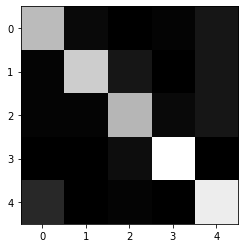

In [18]:
y_pred = model.predict(X_test)
y_p = [np.argmax(yy) for yy in y_pred]
y_tp = [np.argmax(yy) for yy in y_test]
plt.imshow(confusion_matrix(y_tp, y_p), 'gray')
print(confusion_matrix(y_tp, y_p))

In [ ]:
with open('./Checkpoints/Model/fruit_classify_3l_resnet.json', 'w') as model_write:
    model_write.write(model.to_json())
model.save('./Checkpoints/Weight/fruit_classify_3l_resnet.h5')